# Running a backtest

Minimal example: load data, pick a strategy, run it, look at results.

In [1]:
import sandtable as st

## Setup

In [2]:
data = st.DataHandler(
    provider=st.CSVProvider("../data/fixtures"),
    universe=["SPY"]
)
data.load("2019-01-01", "2023-12-31")

strategy = st.MACrossoverStrategy(fast_period=10, slow_period=30)

print(f"Loaded {len(data)} bars")

Loaded 1258 bars


## Run it

In [3]:
result = st.run_backtest(
    strategy=strategy,
    data=data,
    initial_capital=100_000,
    position_size_pct=0.10,
)

[2026-02-22 18:25:20] INFO:sandtable.api: Running backtest: MACrossoverStrategy on ['SPY']
[2026-02-22 18:25:20] INFO:sandtable.core.backtest: Starting backtest: SPY with 1258 bars
[2026-02-22 18:25:20] INFO:sandtable.core.backtest: Backtest complete: processed 1258 bars
[2026-02-22 18:25:20] INFO:sandtable.api: Backtest finished: return=0.22%, sharpe=0.03


## Metrics

In [4]:
m = result.metrics

print(f"Total Return:  {m.total_return:.2%}")
print(f"CAGR:          {m.cagr:.2%}")
print(f"Sharpe Ratio:  {m.sharpe_ratio:.3f}")
print(f"Sortino Ratio: {m.sortino_ratio:.3f}")
print(f"Max Drawdown:  {m.max_drawdown:.2%}")
print(f"Win Rate:      {m.win_rate:.2%}")
print(f"Profit Factor: {m.profit_factor:.2f}")
print(f"Num Trades:    {m.num_trades}")

Total Return:  0.22%
CAGR:          0.04%
Sharpe Ratio:  0.032
Sortino Ratio: 0.045
Max Drawdown:  3.38%
Win Rate:      35.14%
Profit Factor: 0.89
Num Trades:    37


## Equity curve

<Axes: title={'center': 'Equity Curve'}, xlabel='date'>

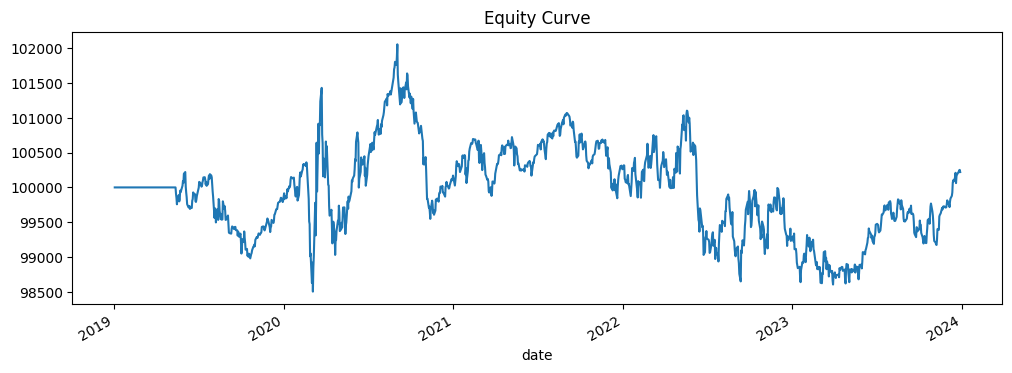

In [5]:
import pandas as pd

equity = pd.DataFrame([
    {"date": pt.timestamp, "equity": pt.equity, "cash": pt.cash}
    for pt in result.equity_curve
]).set_index("date")

equity["equity"].plot(figsize=(12, 4), title="Equity Curve")

## Built-in plot

`result.plot()` gives you equity + drawdown + trades on one figure.

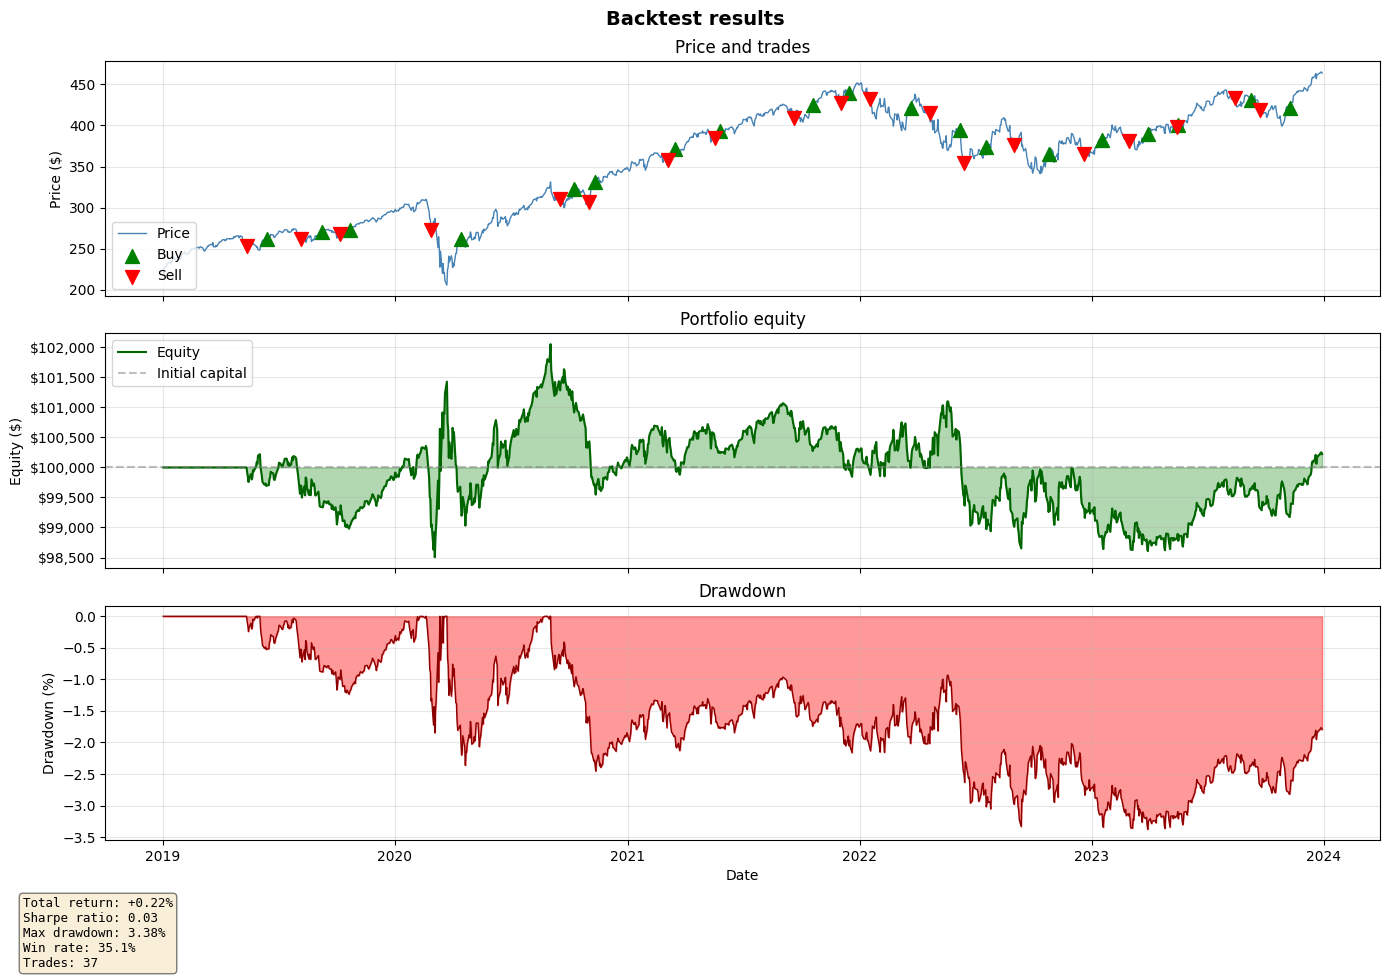

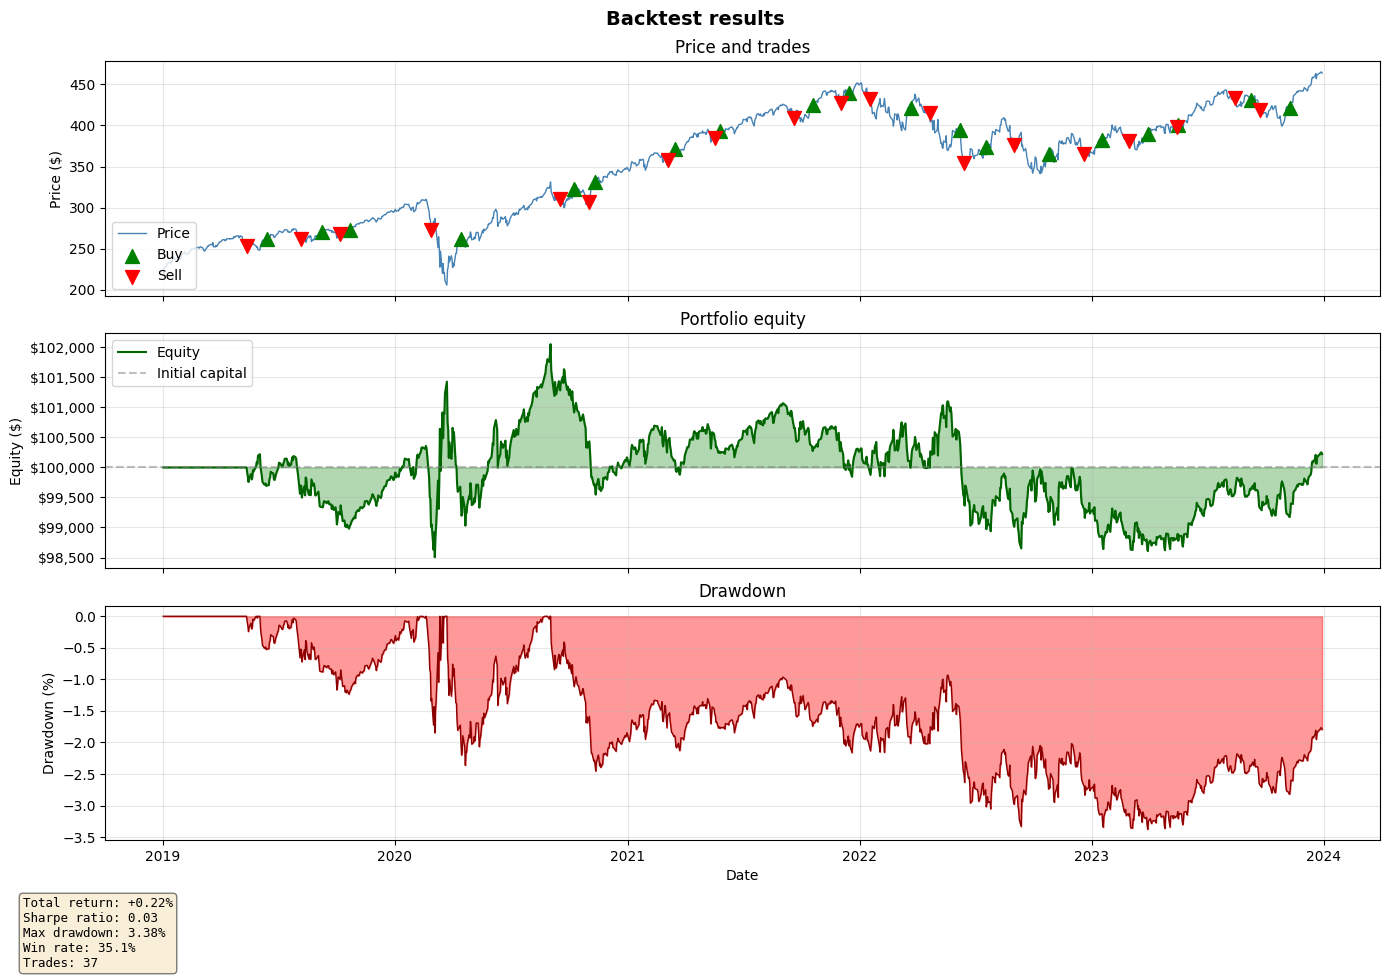

In [6]:
result.plot()

## Adding risk management

You can layer on risk rules that sit between signal generation and order execution. They can resize or reject orders.

In [7]:
data.reset()
strategy.reset()

risk_mgr = st.RiskManager(rules=[
    st.MaxDrawdownRule(max_drawdown_pct=0.10),
    st.MaxPositionSizeRule(max_position_pct=0.20),
])

result_risk = st.run_backtest(
    strategy=strategy,
    data=data,
    initial_capital=100_000,
    risk_manager=risk_mgr,
)

print(f"Sharpe (no risk):   {result.metrics.sharpe_ratio:.3f}")
print(f"Sharpe (with risk): {result_risk.metrics.sharpe_ratio:.3f}")
print(f"Max DD (no risk):   {result.metrics.max_drawdown:.2%}")
print(f"Max DD (with risk): {result_risk.metrics.max_drawdown:.2%}")

[2026-02-22 18:25:25] INFO:sandtable.api: Running backtest: MACrossoverStrategy on ['SPY']
[2026-02-22 18:25:25] INFO:sandtable.core.backtest: Starting backtest: SPY with 1258 bars
[2026-02-22 18:25:25] INFO:sandtable.core.backtest: Backtest complete: processed 1258 bars
[2026-02-22 18:25:25] INFO:sandtable.api: Backtest finished: return=-3.18%, sharpe=-0.42


Sharpe (no risk):   0.032
Sharpe (with risk): -0.422
Max DD (no risk):   3.38%
Max DD (with risk): 4.70%


## Slippage and commission

For more realistic fills you can pass slippage and commission models.

In [8]:
data.reset()
strategy.reset()

result_costs = st.run_backtest(
    strategy=strategy,
    data=data,
    initial_capital=100_000,
    slippage=st.FixedSlippage(bps=10),
    commission=0.005,  # per share
)

print(f"Return (no costs):   {result.metrics.total_return:.2%}")
print(f"Return (with costs): {result_costs.metrics.total_return:.2%}")

[2026-02-22 18:25:25] INFO:sandtable.api: Running backtest: MACrossoverStrategy on ['SPY']
[2026-02-22 18:25:25] INFO:sandtable.core.backtest: Starting backtest: SPY with 1258 bars
[2026-02-22 18:25:26] INFO:sandtable.core.backtest: Backtest complete: processed 1258 bars
[2026-02-22 18:25:26] INFO:sandtable.api: Backtest finished: return=-0.51%, sharpe=-0.04


Return (no costs):   0.22%
Return (with costs): -0.51%
